In [2]:

import random

def generate_sample_data(num, seed=1):
    is_cv_list = []
    is_treat_list = []
    feature_vector_list = []

    random_instance = random.Random(seed)

    feature_num = 8
    base_weight = [0.02, 0.03, 0.05, -0.04, 0.00, 0.00, 0.00, 0.00]
    lift_weight = [0.00, 0.00, 0.00, 0.05, -0.05, 0.00, 0.00, 0.00]

    for i in range(num):
        is_treat = random_instance.choice((True, False))
        feature_vector = [random_instance.random() for n in range(feature_num)]
        cv_rate = sum([feature_vector[n] * base_weight[n] for n in range(feature_num)])

        if is_treat:
            cv_rate += sum([feature_vector[n] * lift_weight[n] for n in range(feature_num)])

        is_cv = cv_rate > random_instance.random()

        is_cv_list.append(is_cv)
        is_treat_list.append(is_treat)
        feature_vector_list.append(feature_vector)

    return is_cv_list, is_treat_list, feature_vector_list


In [3]:
generate_sample_data(2)

([False, False],
 [True, False],
 [[0.5692038748222122,
   0.8022650611681835,
   0.06310682188770933,
   0.11791870367106105,
   0.7609624449125756,
   0.47224524357611664,
   0.37961522332372777,
   0.20995480637147712],
  [0.43276706790505337,
   0.762280082457942,
   0.0021060533511106927,
   0.4453871940548014,
   0.7215400323407826,
   0.22876222127045265,
   0.9452706955539223,
   0.9014274576114836]])

In [4]:

from sklearn.linear_model import LogisticRegression

# trainデータの生成
sample_num = 100000
train_is_cv_list, train_is_treat_list, train_feature_vector_list = generate_sample_data(sample_num, seed=1)

# 学習器の生成
treat_model = LogisticRegression(C=0.01)
control_model = LogisticRegression(C=0.01)

# データをtreatmentとcontrolに分離
treat_is_cv_list = []
treat_feature_vector_list = []
control_is_cv_list = []
control_feature_vector_list = []

for i in range(sample_num):
    if train_is_treat_list[i]:
        treat_is_cv_list.append(train_is_cv_list[i])
        treat_feature_vector_list.append(train_feature_vector_list[i])
    else:
        control_is_cv_list.append(train_is_cv_list[i])
        control_feature_vector_list.append(train_feature_vector_list[i])

# 学習器の構築
treat_model.fit(treat_feature_vector_list, treat_is_cv_list)
control_model.fit(control_feature_vector_list, control_is_cv_list)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
print("treatment_cvr", treat_is_cv_list.count(True) / len(treat_is_cv_list))
print("control_cvr", control_is_cv_list.count(True) / len(control_is_cv_list))


treatment_cvr 0.0309636212163288
control_cvr 0.029544629532529343


In [6]:
treat_model.coef_

array([[-0.1460999 ,  0.04339487,  0.32390363, -0.19761846, -1.32800043,
        -0.36709028, -0.5011928 , -0.44477014]])

In [8]:
control_model.coef_

array([[-0.07800748,  0.02601851,  0.36912944, -1.07796407, -0.4789997 ,
        -0.46711458, -0.42302397, -0.38779378]])

In [9]:
# seedを変えて、テストデータを生成
test_is_cv_list, test_is_treat_list, test_feature_vector_list = generate_sample_data(sample_num, seed=42)

# それぞれの学習器でCVRを予測
treat_score = treat_model.predict_proba(test_feature_vector_list)
control_score = control_model.predict_proba(test_feature_vector_list)

# スコアの算出、スコアは実験群の予測CVR / 統制群の予測CVR
# predict_probaはクラス所属確率のリストを返すため1番目を参照する
# model.classes_ を参照すると、どのクラスが何番目かを知ることができる
score_list = treat_score[:,1] / control_score[:,1]

In [25]:
%config InlineBackend.figure_formats = {'png', 'retina'}

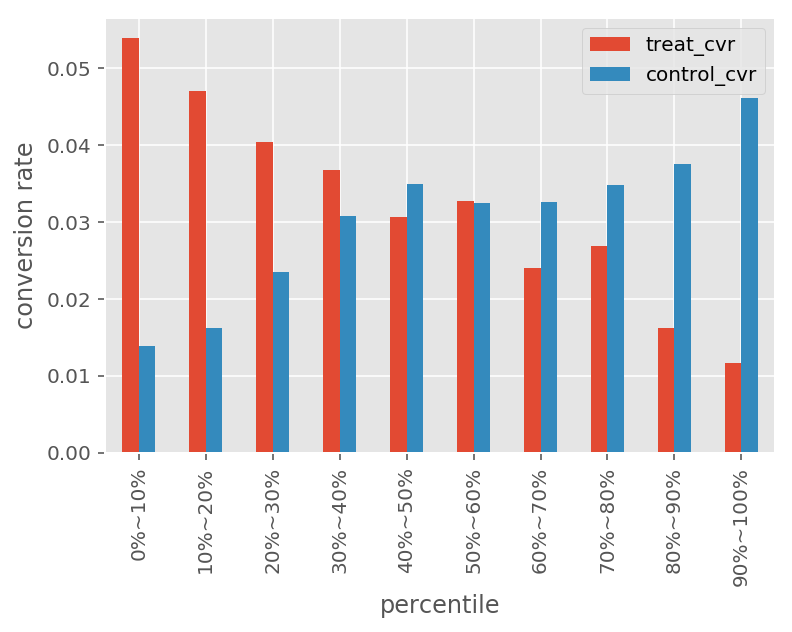

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
plt.style.use('ggplot')

%matplotlib inline 

# スコアが高い順に並べ替える
result = list(zip(test_is_cv_list, test_is_treat_list, score_list))
result.sort(key=itemgetter(2), reverse=True)

qdf = pd.DataFrame(columns=('treat_cvr', 'control_cvr'))

for n in range(10):
    start = int(n * len(result) / 10)
    end = int((n + 1) * len(result) / 10) - 1
    quantiled_result = result[start:end]

    treat_uu = list(map(lambda item:item[1], quantiled_result)).count(True)
    control_uu = list(map(lambda item:item[1], quantiled_result)).count(False)

    treat_cv = [item[0] for item in quantiled_result if item[1] == True].count(True)
    control_cv = [item[0] for item in quantiled_result if item[1] == False].count(True)

    treat_cvr = treat_cv / treat_uu
    control_cvr = control_cv / control_uu
    
    label = "{}%~{}%".format(n*10, (n+1)*10)
    qdf.loc[label] = [treat_cvr, control_cvr]

qdf.plot.bar()
plt.xlabel("percentile")
plt.ylabel("conversion rate")

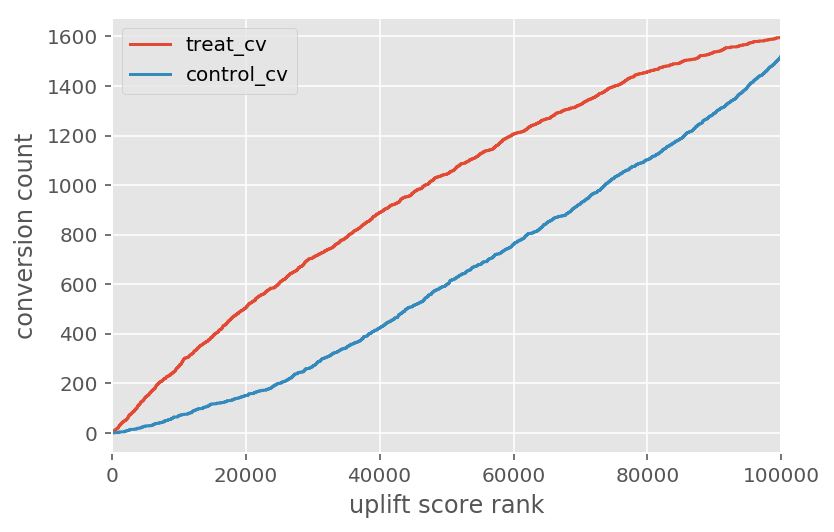

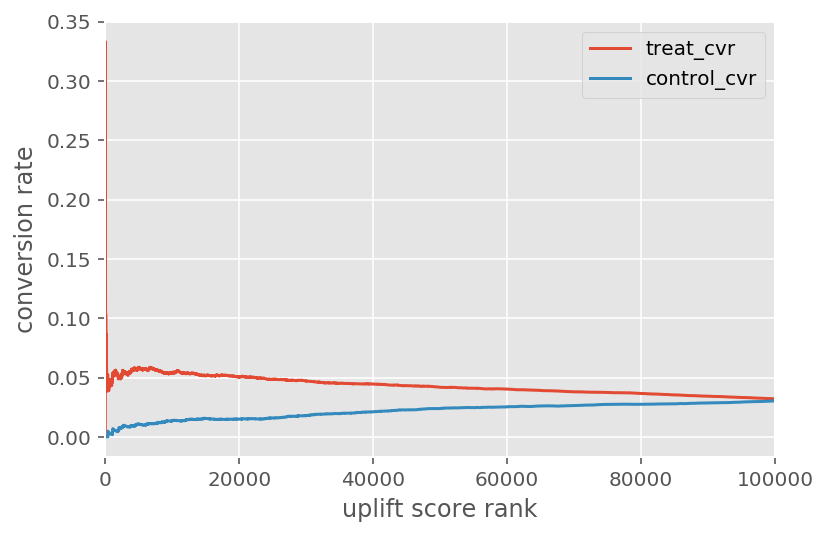

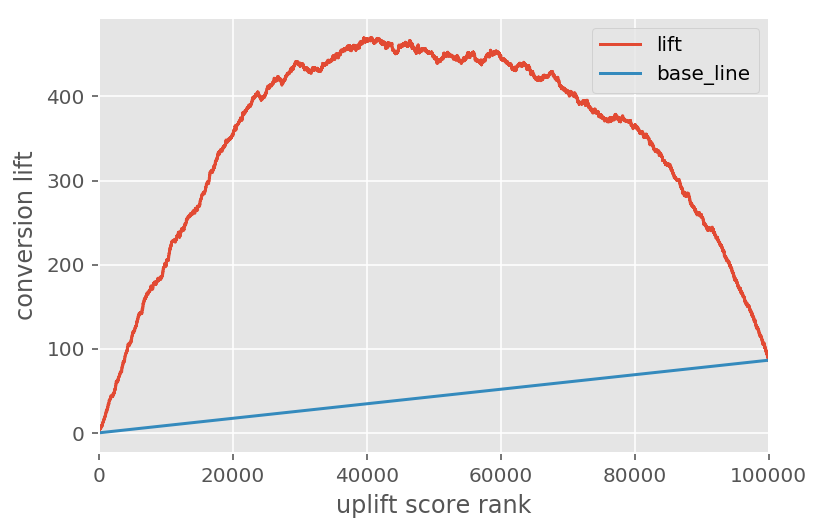

In [37]:
# スコア順に集計を行う
treat_uu = 0
control_uu = 0
treat_cv = 0
control_cv = 0
treat_cvr = 0.0
control_cvr = 0.0
lift = 0.0

stat_data = []

for is_cv, is_treat, score in result:
    if is_treat:
        treat_uu += 1
        if is_cv:
            treat_cv += 1
        treat_cvr = treat_cv / treat_uu
    else:
        control_uu += 1
        if is_cv:
            control_cv += 1
        control_cvr = control_cv / control_uu

    # コンバージョンレートの差に実験群の人数を掛けることでliftを算出
    lift = (treat_cvr - control_cvr) * treat_uu

    stat_data.append([is_cv, is_treat, score, treat_uu, control_uu, treat_cv, control_cv, treat_cvr, control_cvr, lift])

# 統計データを、DataFrameに変換する
df = pd.DataFrame(stat_data)
df.columns = ["is_cv", "is_treat", "score", "treat_uu", "control_uu", "treat_cv", "control_cv", "treat_cvr", "control_cvr", "lift"]

# ベースラインを書き加える
df["base_line"] = df.index * df["lift"][len(df.index) - 1] / len(df.index)

# 可視化を行う
df.plot(y=["treat_cv", "control_cv"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion count")

df.plot(y=["treat_cvr", "control_cvr"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion rate")


df.plot(y=["lift", "base_line"])
plt.xlabel("uplift score rank")
plt.ylabel("conversion lift")


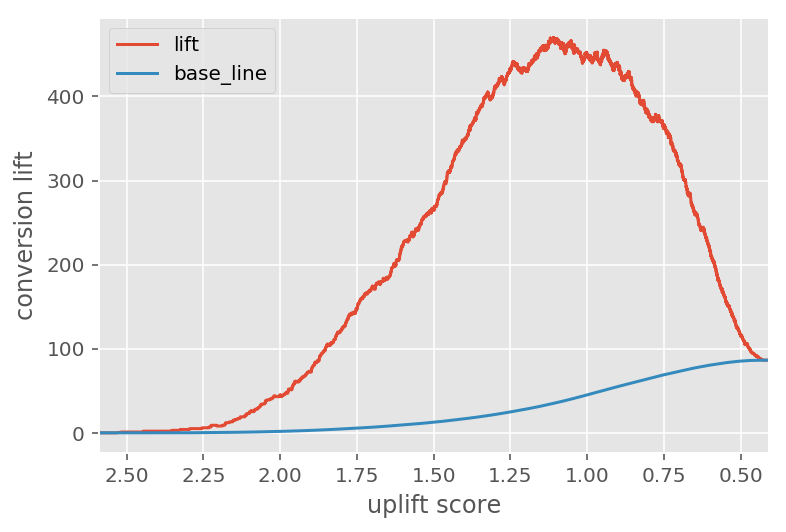

In [44]:
# df.plot(x="score", y=["treat_cv", "control_cv"], title="conversion count")
# df.plot(x="score", y=["treat_cvr", "control_cvr"], title="conversion rate")
df.plot(x="score", y=["lift", "base_line"])
plt.xlabel("uplift score")
plt.ylabel("conversion lift")



In [38]:
auuc = (df["lift"] - df["base_line"]).sum() / len(df["lift"])
print("AUUC:", auuc)

AUUC: 302.246369848
